conversion time (ms): 2.124


eye rules-princ.n3 --turtle ./data/tests/princ2.n3 ./data/tests/princ2.1.n3 --pass-only-new
EYE v9.11.4 (2024-03-04)
SWI-Prolog version 9.0.4
starting 23 [msec cputime] 26 [msec walltime]
GET file:///Users/wvw/git/pm/pqn/infer/rules-princ.n3 SC=26
GET file:///Users/wvw/git/pm/pqn/infer/data/tests/princ2.n3 SC=33
GET file:///Users/wvw/git/pm/pqn/infer/data/tests/princ2.1.n3 SC=3
networking 8 [msec cputime] 8 [msec walltime]
reasoning 13 [msec cputime] 13 [msec walltime]
2024-05-09T15:37:14.130Z in=62 out=126 ent=63 step=53 brake=5 inf=405770 sec=0.044 inf/sec=9222045



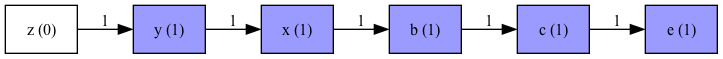

In [26]:
import sys
sys.path.append('../convert')

import os
from pm4py.visualization.dfg import visualizer as dfg_visualizer
from convert_dfg import convert_rdf_dfg

# - tc
#folder = "tc/4"
#outfile = f"data/out/{folder.replace('/', '_')}.n3"
#os.system(f"eye rules-princ.n3 --turtle ./data/{folder}/disc.n3 ./data/{folder}/norm.n3 --pass-only-new > {outfile}") 

# - tests
files = [ "princ2.n3", "princ2.1.n3" ]
outfile = f"./data/out/{files[1]}"
os.system(f"eye rules-princ.n3 --turtle ./data/tests/{files[0]} ./data/tests/{files[1]} --pass-only-new > {outfile}") 

dfg = convert_rdf_dfg(outfile, "")
# print(dfg)
dfg_visualizer.view(dfg_visualizer.apply(dfg))